<a href="https://colab.research.google.com/github/Sewanmpm/SlumImprovment/blob/main/roadshadowcentervector01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install opencv-python numpy


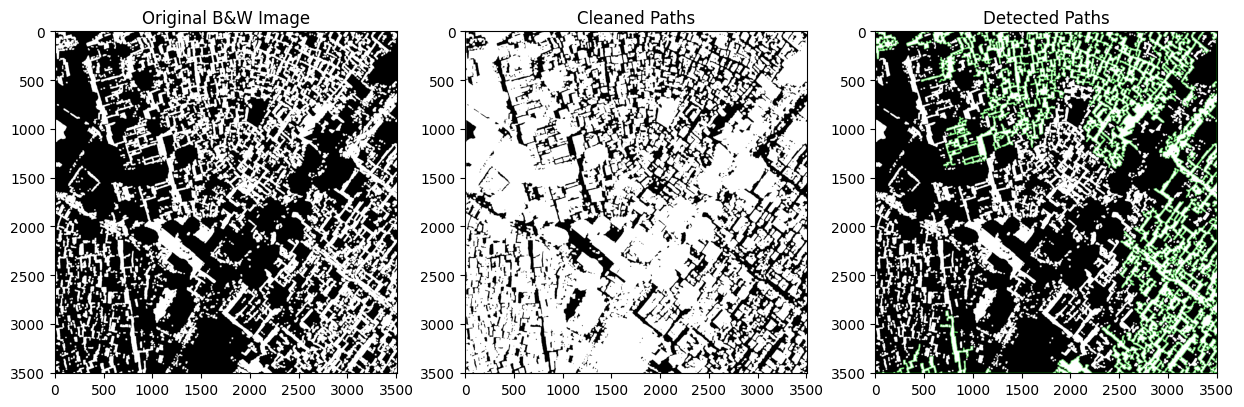

True

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your black-and-white image where shadows are black
image_path = '/root/cleaned_paths.png'  # Update this to your image's file path
bw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Assuming black (low intensity) represents shadows in your image
# You may need to invert the image if white represents shadows
# Uncomment the following line to invert the image if necessary
# bw_image = 255 - bw_image

# Identify potential paths by isolating dark (black) regions
# Since your image is already a mask, this might be unnecessary,
# but you can apply additional thresholds if needed to refine it:
_, paths_mask = cv2.threshold(bw_image, 127, 255, cv2.THRESH_BINARY_INV)

# Morphological operations to clean up noise and enhance path structures
kernel = np.ones((5, 5), np.uint8)  # You can adjust the kernel size as needed
cleaned_paths = cv2.morphologyEx(paths_mask, cv2.MORPH_OPEN, kernel)
cleaned_paths = cv2.dilate(cleaned_paths, kernel, iterations=2)  # Increase path width

# Optionally, find contours (which could represent paths)
contours, _ = cv2.findContours(cleaned_paths, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_img = cv2.cvtColor(bw_image, cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw colored contours
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Draw contours in green

# Show the original and processed images
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(bw_image, cmap='gray')
plt.title('Original B&W Image')
plt.subplot(1, 3, 2)
plt.imshow(cleaned_paths, cmap='gray')
plt.title('Cleaned Paths')
plt.subplot(1, 3, 3)
plt.imshow(contour_img)
plt.title('Detected Paths')
plt.show()

# Save the cleaned paths image
cleaned_paths_output_path = '/root/ground road.png'  # Update this to your desired file path
cv2.imwrite(cleaned_paths_output_path, cleaned_paths)


In [5]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import img_as_bool, img_as_ubyte

# Invert the horse image
image = invert(cleaned_paths)

# Convert image to binary (0 or 1)
binary_image = img_as_bool(image)

# Perform skeletonization
skeleton = skeletonize(binary_image)



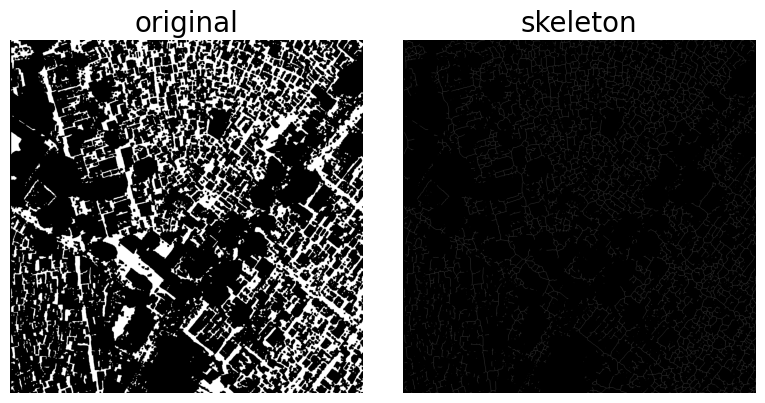

In [9]:
from skimage.morphology import skeletonize, dilation, square
import imageio
# Dilate the skeleton: Increase '3' to make thicker lines
dilation_skeleton = dilation(skeleton, square(1))  # Change square(3) for different thickness
skeleton_uint8 = (skeleton * 255).astype(np.uint8)

# Save the formatted skeleton image
imageio.imsave('skeleton.png', skeleton_uint8)


# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

# Save the cleaned paths image


In [10]:
import numpy as np
import networkx as nx

def skeleton_to_graph(skeleton):
    # Initialize an empty graph
    G = nx.Graph()

    # Get the dimensions of the skeleton
    rows, cols = skeleton.shape

    # Define offsets for 8-connectivity (including diagonal connections)
    neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]

    # Iterate over the skeleton
    for y in range(rows):
        for x in range(cols):
            # Check if current pixel is part of the skeleton
            if skeleton[y, x] == 1:
                # Add the current pixel as a node in the graph
                G.add_node((x, y))

                # Check all possible neighbors
                for dx, dy in neighbors:
                    new_x, new_y = x + dx, y + dy

                    # Make sure neighbor indices are within the image boundaries
                    if 0 <= new_x < cols and 0 <= new_y < rows:
                        # Check if neighbor is also part of the skeleton
                        if skeleton[new_y, new_x] == 1:
                            # Add an edge between the current pixel and the neighbor
                            G.add_edge((x, y), (new_x, new_y))

    return G

# Here you would use the function with your skeletonized data
# skeleton = ... (your skeletonized image)
# graph = skeleton_to_graph(skeleton)
import numpy as np
import networkx as nx
from skimage.morphology import skeletonize, label

def skeleton_to_graph2(skeleton):
    # Initialize an empty graph
    G = nx.Graph()

    # Get the dimensions of the skeleton
    rows, cols = skeleton.shape

    # Identify junctions and endpoints
    # Initialize arrays to hold the identified junctions and endpoints
    junctions = set()
    endpoints = set()

    # Define neighbor offsets for connectivity
    neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]

    # Find junctions and endpoints
    for y in range(rows):
        for x in range(cols):
            if skeleton[y, x] == 1:  # If the pixel is part of the skeleton
                neighbor_count = sum(skeleton[y + dy, x + dx] for dx, dy in neighbors if 0 <= x + dx < cols and 0 <= y + dy < rows)
                if neighbor_count > 2:
                    junctions.add((x, y))
                elif neighbor_count == 1:
                    endpoints.add((x, y))

    # Add junctions and endpoints as nodes
    for junction in junctions:
        G.add_node(junction)
    for endpoint in endpoints:
        G.add_node(endpoint)

    # Define a method to trace a line from an endpoint or junction to another node
    def trace_line(start, end=None):
        x, y = start
        line = [start]
        while True:
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                if (nx, ny) != end and (nx, ny) in line:
                    continue  # Avoid looping back on itself
                if 0 <= nx < cols and 0 <= ny < rows and skeleton[ny, nx] == 1:
                    if (nx, ny) in junctions or (nx, ny) in endpoints:
                        # Reached another node; stop tracing
                        return start, (nx, ny), line
                    elif (nx, ny) not in line:  # Continue tracing
                        line.append((nx, ny))
                        x, y = nx, ny
                        break
            else:
                # No more directions to move
                break
        return start, None, line  # In case of isolated segments, though unlikely

    # Trace lines between endpoints and junctions
    visited = set()
    for start in endpoints.union(junctions):
        if start not in visited:
            _, end, line = trace_line(start)
            if end:
                G.add_edge(start, end)
                visited.update(line)

    return G

# Usage
# skeleton = skeletonize(image)  # Assuming 'image' is your binary image
# graph = skeleton_to_graph(skeleton)


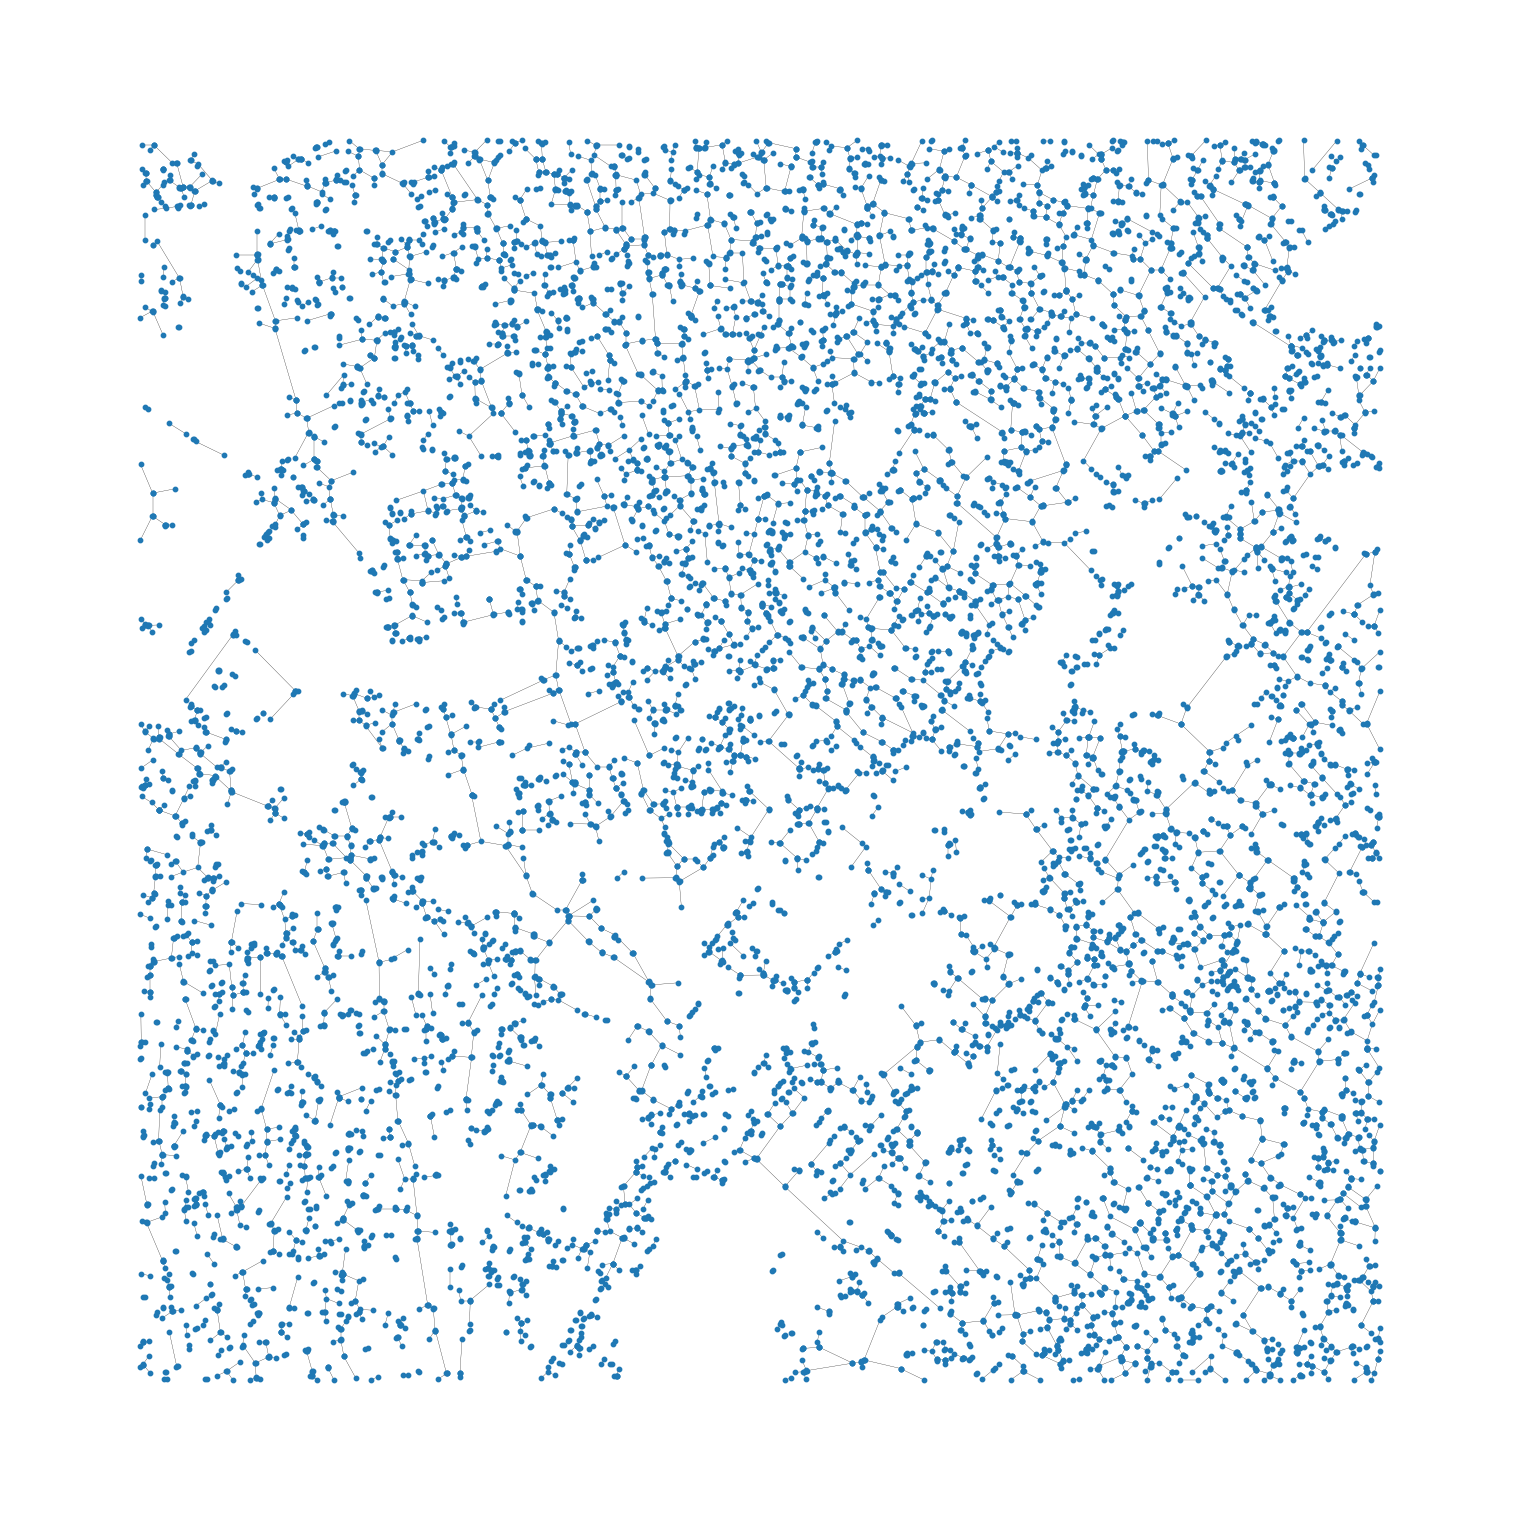

In [42]:
import matplotlib.pyplot as plt
graph = skeleton_to_graph2(skeleton)
# Assuming 'graph' is the graph generated from your 'skeleton_to_graph' function
pos = {node: (node[0], -node[1]) for node in graph.nodes()}  # Flip y-axis for visualization
plt.figure(figsize=(15, 15))  # Adjust the size as needed
nx.draw(graph, pos, node_size=10, width=0.2)  # You can customize this

# Save the graph as SVG
plt.savefig("graph.svg", format='svg')


In [ ]:
graph

In [37]:
import matplotlib.pyplot as plt
import networkx as nx
import math

# Your existing functions
def distance(node1, node2):
    return math.sqrt((node1[0] - node2[0]) ** 2 + (node1[1] - node2[1]) ** 2)

def remove_close_nodes(graph, threshold):
    nodes_to_remove = set()
    for node1 in graph.nodes():
        for node2 in graph.nodes():
            if node1 != node2 and node1 not in nodes_to_remove and node2 not in nodes_to_remove:
                if distance(node1, node2) < threshold:
                    if len(graph[node1]) > len(graph[node2]):
                        nodes_to_remove.add(node2)
                    else:
                        nodes_to_remove.add(node1)
    graph.remove_nodes_from(nodes_to_remove)




In [38]:
# Function to reconnect isolated nodes
def reconnect_isolated_nodes(graph):
    isolated = list(nx.isolates(graph))
    for node in isolated:
        # Find the closest node
        closest_node, min_dist = None, float('inf')
        for potential_neighbor in graph.nodes():
            if potential_neighbor != node:
                dist = distance(node, potential_neighbor)
                if dist < min_dist:
                    closest_node, min_dist = potential_neighbor, dist
        # Connect the isolated node to the closest node
        if closest_node:
            graph.add_edge(node, closest_node)

In [41]:



# Assuming 'skeleton_to_graph2' generates your graph from a skeleton
graph = skeleton_to_graph2(skeleton)

# Remove nodes that are closer than a certain threshold
remove_close_nodes(graph, threshold=6)  # Adjust threshold as needed

# Reconnect isolated nodes to their nearest neighbors
reconnect_isolated_nodes(graph)

# Visualization and saving
pos = {node: (node[0], -node[1]) for node in graph.nodes()}  # Adjust if necessary
plt.figure(figsize=(15, 15))
nx.draw(graph, pos, node_size=5, width=0.7)
plt.savefig("existing_graph.svg", format='svg')
plt.close()

In [44]:
len(graph.nodes)

15339